# Проект по теме "Машинное обучение в бизнесе"

# Описание проекта

Добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.  
  
**Цели и задачи**  
Предоставлены пробы нефти в трёх регионах: в каждом 10,000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

**Шаги для выбора локации:**
- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**  
Данные геологоразведки трёх регионов находятся в файлах: `geo_data_0.csv`, `geo_data_1.csv`, `geo_data_2.csv`
- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).  

**Условия задачи:**  
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для расчёта прибыли.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.  
Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

**План выполнения работы:**  
- 1. Загрузка и подготовка данных  
- 2. Обучение и проверка модели  
- 3. Подготовка к расчёту прибыли  
- 4. Расчёт прибыли и рисков  
    - 4.1 Расчёт прибыли  
    - 4.2 Расчёт рисков  
- 5. Общий вывод  

<a id='секция1'></a>
# 1. Загрузка и подготовка данных

Подключаем библиотеки:
- `pandas` - для работы с таблицами  
- `seaborn` - для визуализации данных
- `display` - для вывода табличных данных
- `sklearn` - инструменты машинного обучения (модели классификации, метрики для исследования качества моделей, разделение данных на тренировочные, валидационные, тестовые выборки)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from numpy.random import RandomState
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Загрузим данные из файлов, выведем первые 10 строк таблиц для первого взгляда на данные.  
Также с помощью метода info() изучим структуры таблиц: типы данных, количество строк, столбцов, пропущенных данных.

In [2]:
def data_read_exam(file_path):
    """
    input:        file_path [object] - путь к файлу
    output:       data [DataFrame] - таблица данных
    description:  функция загружает таблицу функцией read_csv, выводит первые 10 строк на экран,
                  выводит информацию о данных методом info(), считает количество дубликатов
    """
    # читаем данные из .csv файла с помощью метода read_csv()
    data = pd.read_csv(file_path)
    display(data.head(10))
    display(data.info())
    print('Количество дубликатов:', sum(data.duplicated()))
    return data

In [3]:
geo0 = data_read_exam('/datasets/geo_data_0.csv')

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Количество дубликатов: 0


In [4]:
geo1 = data_read_exam('/datasets/geo_data_1.csv')

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Количество дубликатов: 0


In [5]:
geo2 = data_read_exam('/datasets/geo_data_2.csv')

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Количество дубликатов: 0


- Данные соответствуют описанию. Пропусков и дубликатов нет.
- Типы данных соответствуют описанию.
- Посмотрим на гистограммы распределений данных.

In [6]:
def show_hists(data, data_label, num_bins, rug=False, log_scale=False):
    """
    input: data - данные для построения гистограммы
           data_label - описание данных
           num_bins - количество ячеек
    output: None
    description: Функция строит гистограмму и boxplot для выбранного параметра:
                - Плотность распределения (методом distplot() библиотеки seaborn)
                - Boxplot (метод boxplot() библиотеки seaborn)
    """
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(data_label + ". Плотность распределения", fontsize=18)
    axes[0].set_ylabel('плотность', fontsize=15)
    sns.distplot(data, bins=num_bins, rug=rug, ax=axes[0])
    axes[1].set_title(data_label + ". Boxplot", fontsize=18)
    sns.boxplot(data=data, ax=axes[1])
    plt.show()

In [7]:
def show_region(data, name):
    numerics = ['f0', 'f1', 'f2', 'product']
    for column in numerics:
        show_hists(data[column], name + ' ' + column, num_bins=20)

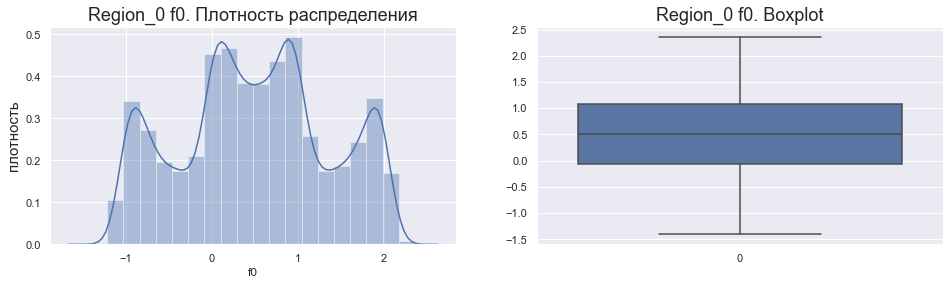

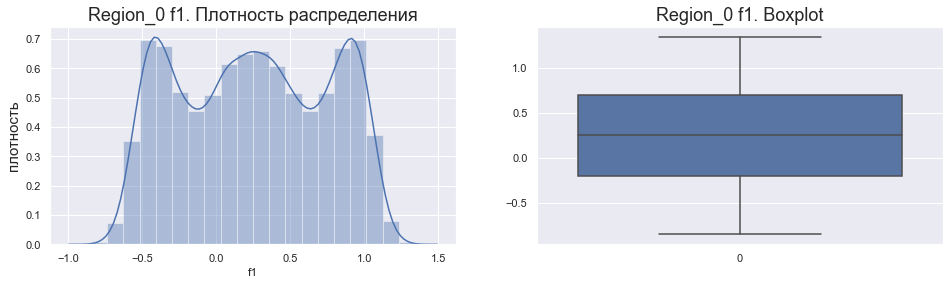

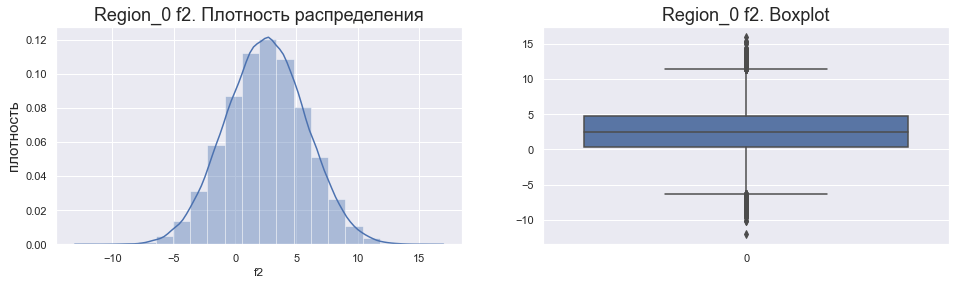

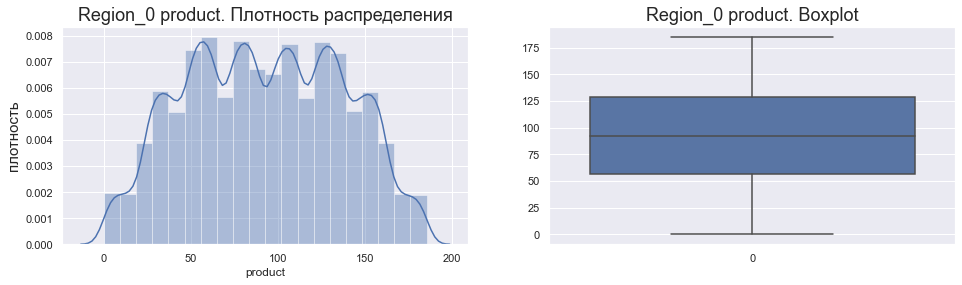

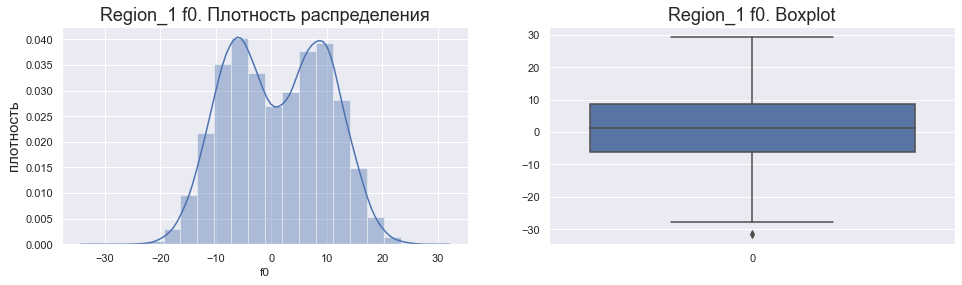

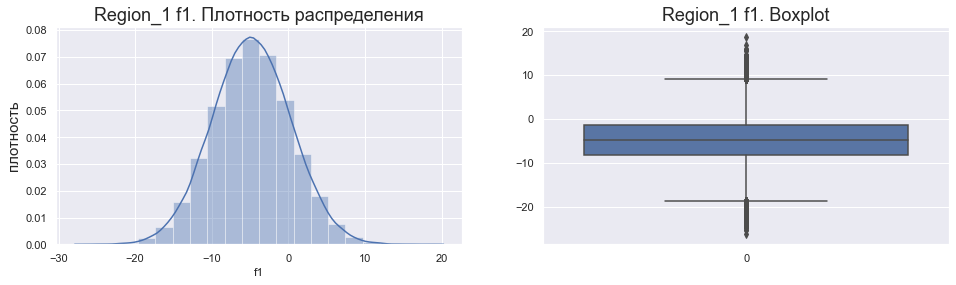

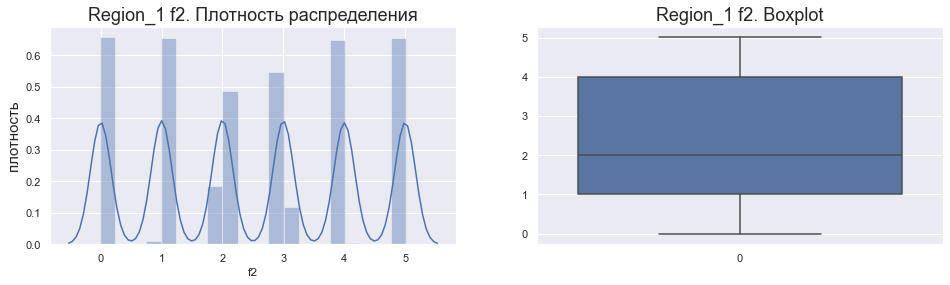

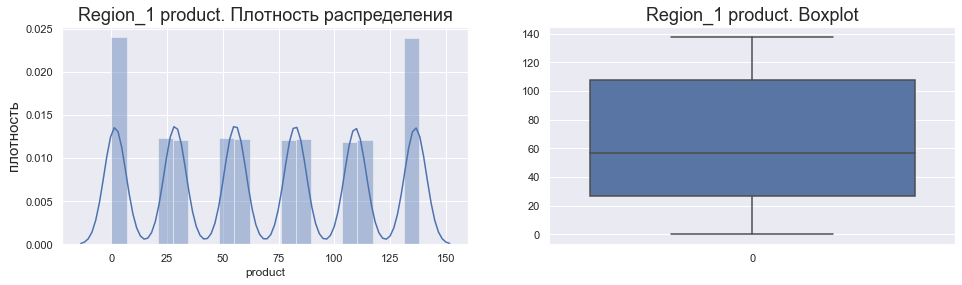

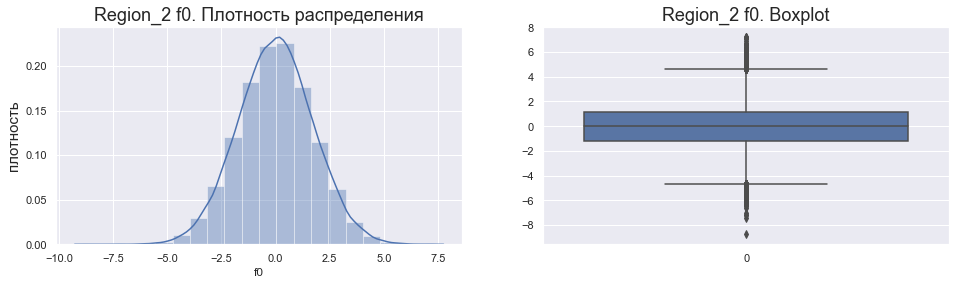

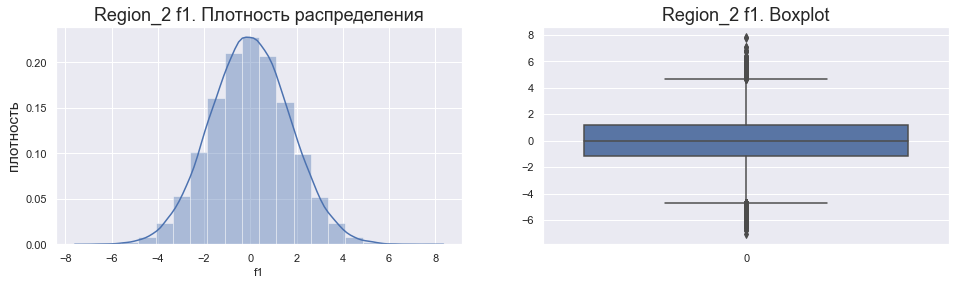

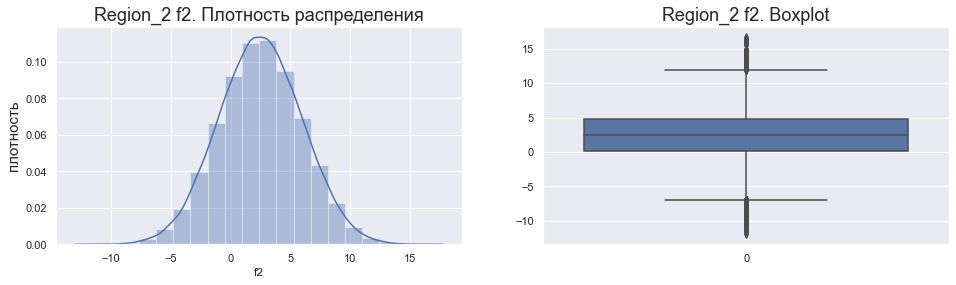

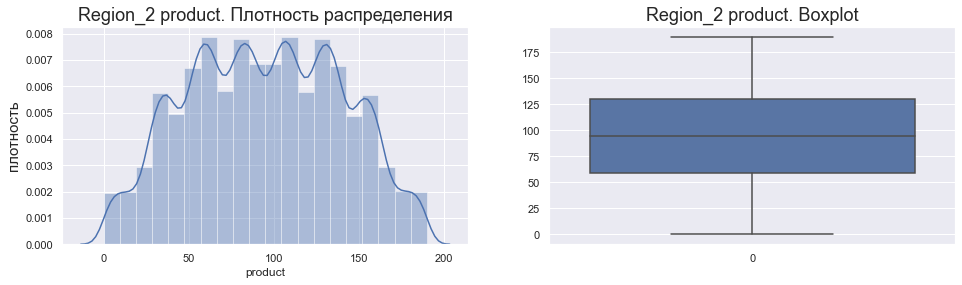

In [8]:
for data, name in [(geo0, 'Region_0'), (geo1, 'Region_1'), (geo2, 'Region_2')]:
    show_region(data, name)

- Распределения некоторых признаков отличаются от нормального. Также присутствуют небольшие выбросы. Так как неизвестно, что означают сами признаки, сложно оценить адекватность распределений и выбросов. 
- Масштабы распределений признаков f0, f1, f2 не сильно отличаются друг от друга (меньше одного порядка). Нет необходимости применять масштабирование. 
- На данном этапе оставим данные как есть.
- Разделим данные на признаки и целевой признак.

In [9]:
feature_names = ['f0', 'f1', 'f2']
target_name = ['product']
X_0 = geo0[feature_names]
y_0 = geo0[target_name]
X_1 = geo1[feature_names]
y_1 = geo1[target_name]
X_2 = geo2[feature_names]
y_2 = geo2[target_name]

### Выводы

- Данные успешно загружены и проанализированы. Данные соответствуют описанию. Пропусков и дубликатов нет. Типы данных соответствуют описанию.
- Распределения некоторых признаков отличаются от нормального. Также присутствуют небольшие выбросы. Так как неизвестно, что означают сами признаки, сложно оценить адекватность распределений и выбросов. Данные оставлены без изменений.

<a id='секция2'></a>
# 2. Обучение и проверка модели

Для каждого региона:  
- Разделим данные на обучающую и валидационную выборки
- Используем модель линейной регрессии по техническому заданию.
- Выведем средний запас предсказанного сырья и RMSE модели.

In [10]:
def model_fit_valid(X, y):
    """
    input: X, y - признаки и целевой признак для модели
    output: y_valid - целевой пизнак валидационной выборки 
            predict - предсказания модели на валидационной выборке
    description: функция разделяет исходные данные на обучающую и валидационную выборки (75/25),
                 обучает модель линейной регрессии, делает предсказания на валидационной выборке,
                 считает и выводит на экран среднее значение предсказаний и RMSE модели.
    """
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)
    print('Train shape:', X_train.shape)
    print('Valid shape:', X_valid.shape)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    predict = model.predict(X_valid)

    predict_mean = predict.mean()
    rmse = mean_squared_error(y_valid, predict)**.5

    print('Cредний запас предсказанного сырья: {:.4f}'.format(predict_mean))
    print('RMSE модели: {:.4f}'.format(rmse))
    
    return y_valid, predict

- **Регион 0**

In [12]:
y_0_valid, predict_0 = model_fit_valid(X_0, y_0)

Train shape: (75000, 3)
Valid shape: (25000, 3)
Cредний запас предсказанного сырья: 92.3988
RMSE модели: 37.7566


- **Регион 1**

In [13]:
y_1_valid, predict_1 = model_fit_valid(X_1, y_1)

Train shape: (75000, 3)
Valid shape: (25000, 3)
Cредний запас предсказанного сырья: 68.7129
RMSE модели: 0.8903


- **Регион 2**

In [14]:
y_2_valid, predict_2 = model_fit_valid(X_2, y_2)

Train shape: (75000, 3)
Valid shape: (25000, 3)
Cредний запас предсказанного сырья: 94.7710
RMSE модели: 40.1459


### Выводы

- В регионах 0 и 2 достаточно высокий средний показатель запаса предсказанного сырья (**92.4** и **94.8** соответственно). Однако RMSE для данных регионов также высок (**37.8** и **40.1** соответственно). Это свидетельствует о неоднозначности показателя, неточности модели регрессии.
- В регионе 1 средний показатель запаса предсказанного сырья составляет **68.7** (ниже остальных регионов). Однако RMSE в данном регионе также мал (**0.9**). Это говорит о точности предсказаний и качестве построенной модели.

<a id='секция3'></a>
# 3. Подготовка к расчёту прибыли

- Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. 
- Сравним полученный объём сырья со средним запасом в каждом регионе.

- **min_product = budget / (top_wells * unit_income)**
    - budget - Бюджет на разработку скважин в регионе — 10 млрд рублей
    - top_wells, samp_wells - При расчёте выбирают 200 лучших скважин из 500 в выборке
    - unit_income - Доход с каждой единицы продукта составляет 450 тыс. рублей

In [15]:
BUDGET = 10**10
TOP_WELLS = 200
SAMP_WELLS = 500
UNIT_INCOME = 4.5*10**5

In [16]:
min_product = BUDGET / (TOP_WELLS * UNIT_INCOME)
print('Минимальный объём продукта с одной скважины для безубыточной разработки: {:.2f}'.format(min_product))

Минимальный объём продукта с одной скважины для безубыточной разработки: 111.11


### Выводы

- Минимальный объём продукта для безубыточной разработки составляет **111.11**. Данный показатель рассчитан при условии выбора 200 лучших скважин из 500 в выборке.
- Данное значение превышает средние значения запасов скважин по всем регионам.

<a id='секция4'></a>
# 4. Расчёт прибыли и рисков 

<a id='секция4.1'></a>
## 4.1 Расчёт прибыли 

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
- Выберем скважины с максимальными значениями предсказаний. Количество скважин зависит от бюджета компании и стоимости разработки одной скважины. В нашем случае выберем случайно 500 точек и отберём 200 с максимальным показателем объёма сырья
- Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
- Рассчитаем прибыль для полученного объёма сырья.

In [17]:
y_0_valid = pd.Series(y_0_valid['product']).reset_index(drop=True)
y_1_valid = pd.Series(y_1_valid['product']).reset_index(drop=True)
y_2_valid = pd.Series(y_2_valid['product']).reset_index(drop=True)

In [18]:
predict_0 = pd.Series(*predict_0.reshape(1,-1))
predict_1 = pd.Series(*predict_1.reshape(1,-1))
predict_2 = pd.Series(*predict_2.reshape(1,-1))

In [19]:
def show_predicted_income(region, top_wells_mean, volume, income):
    print('===', region, '===')
    print('Средний запас сырья среди скважин с максимальным показателем: {:.2f}'.format(top_wells_mean))
    print('Суммарный целевой объём сырья: {:.2f}'.format(volume))
    print('Прибыль для полученного объёма сырья: {:.2f}'.format(income))

In [20]:
state = 42
def predicted_income(target, predicts, region, state, replace=False, show_res=True, return_res=False):
    """
    input: predicts - предсказания линейной модели для объёма сырья
    output: None
    description: - Функция берёт выборку размера SAMP_WELLS, выбирает TOP_WELLS наивысших значений,
                   Функция считает:    среднее значение объёма сырья для выбранных скважин.
                                       суммарный целевой объём сырья
                                       прибыль для полученного объёма сырья
    """
    sample_preds = predicts.sample(n=SAMP_WELLS, 
                                   replace=replace, 
                                   random_state=state)
    top_preds = sample_preds.sort_values(ascending=False)[:TOP_WELLS]
    top_targets = target[top_preds.index]
    top_wells_mean = top_targets.mean()
    volume = sum(top_targets)
    income = volume * UNIT_INCOME - BUDGET
    if show_res:
        show_predicted_income(region, top_wells_mean, volume, income)
    if return_res:
        return income
    

In [21]:
predicted_income(y_0_valid, predict_0, 'Регион 0', state)

=== Регион 0 ===
Средний запас сырья среди скважин с максимальным показателем: 113.15
Суммарный целевой объём сырья: 22629.14
Прибыль для полученного объёма сырья: 183112236.31


In [22]:
predicted_income(y_1_valid, predict_1, 'Регион 1', state)

=== Регион 1 ===
Средний запас сырья среди скважин с максимальным показателем: 115.96
Суммарный целевой объём сырья: 23191.83
Прибыль для полученного объёма сырья: 436323404.69


In [23]:
predicted_income(y_2_valid, predict_2, 'Регион 2', state)

=== Регион 2 ===
Средний запас сырья среди скважин с максимальным показателем: 116.33
Суммарный целевой объём сырья: 23265.40
Прибыль для полученного объёма сырья: 469431517.00


<a id='секция4.2'></a>
## 4.2 Расчёт рисков 

- Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

In [24]:
def show_risks(region, income_mean, conf_int_left, conf_int_right, loss_rate):
    print('===', region, '===')
    print('Средняя прибыль {:.2f} (млн. Р)'.format(income_mean / 10**6))
    print('95% доверительный интервал: {:.2f} : {:.2f} (млн. Р)'.format(conf_int_left / 10**6, conf_int_right / 10**6))
    print('Риск убытков: {:.2f} %'.format(loss_rate * 100))

In [25]:
def risk_calc(target, predicts, region):
    """
    input: predicts - предсказания линейной модели для объёма сырья
    output: None
    description:  - функция реализует технику bootstrap, количество выборок = bootstrap_samples.
                  - Функция берёт выборку размера SAMP_WELLS, выбирает TOP_WELLS наивысших значений,
                    считает общую прибыль income_pred и сохраняет её в списке incomes.
                  - Функция выводит:  оценку средней прибыли
                                      95% доверительный интервал (считается с помощью функции quantile)
                                      риск убытков 
    """
    bootstrap_samples = 1000
    alpha = 0.05
    incomes = []
    state = np.random.RandomState(42)
    for _ in range(bootstrap_samples):
        income = predicted_income(target, predicts, region, state, replace=True, show_res=False, return_res=True)
        incomes.append(income)

    incomes = pd.Series(incomes)
    income_mean = incomes.mean()
    conf_int_left = incomes.quantile(alpha/2)
    conf_int_right = incomes.quantile(1 - alpha/2)
    
    loss_count = 0
    for inc in incomes :
        if inc < 0 :
            loss_count += 1
    loss_rate = loss_count / bootstrap_samples
    #loss_rate = stats.percentileofscore(incomes, 0)
    
    show_risks(region, income_mean, conf_int_left, conf_int_right, loss_rate)

In [26]:
risk_calc(y_0_valid, predict_0, 'Регион 0')

=== Регион 0 ===
Средняя прибыль 399.58 (млн. Р)
95% доверительный интервал: -110.47 : 897.46 (млн. Р)
Риск убытков: 6.00 %


In [27]:
risk_calc(y_1_valid, predict_1, 'Регион 1')

=== Регион 1 ===
Средняя прибыль 452.05 (млн. Р)
95% доверительный интервал: 61.68 : 845.34 (млн. Р)
Риск убытков: 1.50 %


In [28]:
risk_calc(y_2_valid, predict_2, 'Регион 2')

=== Регион 2 ===
Средняя прибыль 375.01 (млн. Р)
95% доверительный интервал: -144.77 : 888.39 (млн. Р)
Риск убытков: 8.00 %


### Выводы

- При расчёте показателей для 200 наилучших скважин из 500 в выборке:
    - Средний запас сырья с одной скважины среди всех регионов (**113.15**, **115.96**, **116.33** соответственно) превосходит минимально необходимый объём **111.11**.
- При применении техники bootstrap:
    - Оценка средней прибыли максимальна для региона 1 (**452.05 млн.**).
    - Только регион 1 прогнозирует прибыльную разработку по 95% доверительному интервалу.
    - Риск убытков для региона 1 (**1.5%**)
    - Рекомендуем регион 1 для разработки. 

<a id='секция5'></a>
# 5. Общий Вывод

- При начальном построении модели и предсказаний:
    - В регионах 0 и 2 достаточно высокий средний показатель запаса предсказанного сырья. Однако RMSE для данных регионов также высок (**37.8** и **40.1** соответственно). Это свидетельствует о неоднозначности показателя, неточности модели регрессии.
    - В регионе 1 средний показатель запаса предсказанного сырья составляет **68.7** (ниже остальных регионов). Однако RMSE в данном регионе также мал (**0.9**). Это говорит о точности предсказаний и качестве построенной модели.
    - Средние показатели предсказанного сырья для одной скважины ниже теоретически необходимых (**111.11**)
- При расчёте показателей для 200 наилучших скважин из выборочных 500:
    - Средний запас сырья с одной скважины среди всех регионов превосходит минимально необходимый объём.
- При применении техники bootstrap:
    - Оценка средней прибыли максимальна для региона 1 (**452.05 млн.**).
    - Только регион 1 прогнозирует прибыльную разработку по 95% доверительному интервалу.
    - Риск убытков для региона 1 (**1.5%**)
- **Рекомендуем регион 1 для разработки.** 